In [2]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [2]:
if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. Neural nets can be very slow without a GPU.")
  if "google.colab" in sys.modules:
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
  if "kaggle_secrets" in sys.modules:
    print("Go to Settings > Accelerator and select GPU.")

## § 16.1.	Generating Shakespearean Text Using a Character RNN

### § 16.1.1.	Creating the Training Dataset

In [3]:
import tensorflow as tf

In [4]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [5]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [6]:
# added ex-post: shows all 39 distinct characters (after converting to lower case)
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [7]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character", standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [8]:
encoded -= 2 # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2 # number of distinct chars = 39
dataset_size = len(encoded) # total number of chars = 1,115,394

In [9]:
n_tokens # added ex-post

39

In [10]:
dataset_size # added ex-post

1115394

In [11]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
  if shuffle:
    ds = ds.shuffle(buffer_size=100_000, seed=seed)
  ds = ds.batch(batch_size)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [12]:
# added ex-post: a simple example using to_dataset()
# There's just 1 sample in this dataset: the input represents "to b", the output "o be"
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [13]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True, seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

### § 16.1.2.	Building and Training the Char-RNN Model

In [14]:
tf.random.set_seed(42) # added ex-post: ensures reproducibility

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True
)
history = model.fit(train_set,
                    epochs=10,
                    validation_data=valid_set,
                    callbacks=[model_ckpt])

Epoch 1/10
31247/31247 [==============================] - 443s 13ms/step - loss: 1.3969 - accuracy: 0.5718 - val_loss: 1.6157 - val_accuracy: 0.5312
Epoch 2/10
31247/31247 [==============================] - 445s 14ms/step - loss: 1.2931 - accuracy: 0.5972 - val_loss: 1.5861 - val_accuracy: 0.5394
Epoch 3/10
31247/31247 [==============================] - 445s 14ms/step - loss: 1.2747 - accuracy: 0.6015 - val_loss: 1.5680 - val_accuracy: 0.5443
Epoch 4/10
31247/31247 [==============================] - 445s 14ms/step - loss: 1.2652 - accuracy: 0.6035 - val_loss: 1.5649 - val_accuracy: 0.5458
Epoch 5/10
31247/31247 [==============================] - 441s 13ms/step - loss: 1.2584 - accuracy: 0.6051 - val_loss: 1.5631 - val_accuracy: 0.5446
Epoch 6/10
31247/31247 [==============================] - 442s 14ms/step - loss: 1.2533 - accuracy: 0.6062 - val_loss: 1.5552 - val_accuracy: 0.5456
Epoch 7/10
31247/31247 [==============================] - 446s 14ms/step - loss: 1.2495 - accuracy: 0.6071

In [17]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2), # no <PAD> or <UNK> tokens
    model
])

In [20]:
# added ex-post: downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

In [22]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba) # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 78ms/step


'e'

### § 16.1.3.	Generating Fake Shakespearean Text

In [23]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]]) # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8) # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [24]:
def next_char(text, temperature=1):
  y_proba = shakespeare_model.predict([text])[0, -1:]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
  return text_vec_layer.get_vocabulary()[char_id + 2]

In [25]:
def extend_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [26]:
tf.random.set_seed(42)
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 31ms/step
To be or not to be the duke
as it is a proper strange death,
and the


In [27]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 47ms/step
To be or not to begg, i
point and through you are to-morrow?

romeo:


In [28]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 34ms/step
To be or not to bepevicm-vilv!?$mz?gmjz :3?ljb'va;!td&
i.ur3l'-j!3em


### § 16.1.4.	Stateful RNN

In [29]:
def to_dataset_for_stateful_rnn(sequence, length):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1, shift=length, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000], length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [30]:
# added ex-post: simple ex. using to_dataset_for_stateful_rnn()
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [31]:
# added ex-post: one way to prepare a batched dataset for a stateful RNN

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

In [32]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [33]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [34]:
# added ex-post: use a different directory to save the checkpoints
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True
)

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set,
                    epochs=10,
                    validation_data=stateful_valid_set,
                    callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/10
9999/9999 [==============================] - 93s 9ms/step - loss: 1.8640 - accuracy: 0.4507 - val_loss: 1.6990 - val_accuracy: 0.4910
Epoch 2/10
9999/9999 [==============================] - 92s 9ms/step - loss: 1.5606 - accuracy: 0.5289 - val_loss: 1.6133 - val_accuracy: 0.5127
Epoch 3/10
9999/9999 [==============================] - 92s 9ms/step - loss: 1.4838 - accuracy: 0.5487 - val_loss: 1.5806 - val_accuracy: 0.5231
Epoch 4/10
9999/9999 [==============================] - 93s 9ms/step - loss: 1.4441 - accuracy: 0.5589 - val_loss: 1.5595 - val_accuracy: 0.5309
Epoch 5/10
9999/9999 [==============================] - 91s 9ms/step - loss: 1.4197 - accuracy: 0.5650 - val_loss: 1.5453 - val_accuracy: 0.5338
Epoch 6/10
9999/9999 [==============================] - 92s 9ms/step - loss: 1.4032 - accuracy: 0.5693 - val_loss: 1.5377 - val_accuracy: 0.5355
Epoch 7/10
9999/9999 [==============================] - 93s 9ms/step - loss: 1.3914 - accuracy: 0.5722 - val_loss: 1.5294 - val_ac

In [36]:
# added ex-post: converting the stateful RNN to a stateless RNN
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [37]:
stateless_model.build(tf.TensorShape([None, None]))

In [38]:
stateless_model.set_weights(model.get_weights())

In [39]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2), # no <PAD> or <UNK> tokens
    stateless_model
])

In [40]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

1/1 [==============================] - 0s 35ms/step
to be or not to bear:
here is a gentleman to hear in the world,
and 


## § 16.2.	Sentiment Analysis

In [4]:
import tensorflow_datasets as tfds

In [5]:
raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [7]:
for review, label in raw_train_set.take(4):
  print(review.numpy().decode("utf-8"))
  print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development

In [44]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [45]:
# The model will probably not learn anything, we didn't mask the padding tokens
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set,
                    epochs=2,
                    validation_data=valid_set)

Epoch 1/2
704/704 [==============================] - 50s 66ms/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/2
704/704 [==============================] - 26s 37ms/step - loss: 0.6926 - accuracy: 0.5031 - val_loss: 0.6935 - val_accuracy: 0.5000


### § 16.2.1.	Masking

In [46]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True), # now we are
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5
704/704 [==============================] - 53s 68ms/step - loss: 0.5210 - accuracy: 0.7298 - val_loss: 0.4301 - val_accuracy: 0.8188
Epoch 2/5
704/704 [==============================] - 28s 40ms/step - loss: 0.3453 - accuracy: 0.8542 - val_loss: 0.3381 - val_accuracy: 0.8484
Epoch 3/5
704/704 [==============================] - 26s 37ms/step - loss: 0.2905 - accuracy: 0.8811 - val_loss: 0.3023 - val_accuracy: 0.8740
Epoch 4/5
704/704 [==============================] - 27s 38ms/step - loss: 0.2696 - accuracy: 0.8918 - val_loss: 0.3064 - val_accuracy: 0.8672
Epoch 5/5
704/704 [==============================] - 26s 37ms/step - loss: 0.2528 - accuracy: 0.8996 - val_loss: 0.3237 - val_accuracy: 0.8504


In [47]:
# or, using manual masking
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [48]:
# added ex-post: compile & trains the model
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5
704/704 [==============================] - 57s 72ms/step - loss: 0.5070 - accuracy: 0.7443 - val_loss: 0.3881 - val_accuracy: 0.8360
Epoch 2/5
704/704 [==============================] - 29s 40ms/step - loss: 0.3571 - accuracy: 0.8474 - val_loss: 0.3204 - val_accuracy: 0.8668
Epoch 3/5
704/704 [==============================] - 27s 38ms/step - loss: 0.2983 - accuracy: 0.8769 - val_loss: 0.3301 - val_accuracy: 0.8560
Epoch 4/5
704/704 [==============================] - 27s 38ms/step - loss: 0.2743 - accuracy: 0.8893 - val_loss: 0.3132 - val_accuracy: 0.8680
Epoch 5/5
704/704 [==============================] - 27s 39ms/step - loss: 0.2583 - accuracy: 0.8948 - val_loss: 0.3109 - val_accuracy: 0.8644


In [49]:
# using ragged tensors
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True
)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [50]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

In [51]:
# added ex-post
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5
704/704 [==============================] - 53s 71ms/step - loss: 0.5206 - accuracy: 0.7443 - val_loss: 0.4574 - val_accuracy: 0.7896
Epoch 2/5
704/704 [==============================] - 30s 43ms/step - loss: 0.4034 - accuracy: 0.8266 - val_loss: 0.3535 - val_accuracy: 0.8488
Epoch 3/5
704/704 [==============================] - 29s 40ms/step - loss: 0.3150 - accuracy: 0.8692 - val_loss: 0.3218 - val_accuracy: 0.8612
Epoch 4/5
704/704 [==============================] - 28s 40ms/step - loss: 0.2843 - accuracy: 0.8841 - val_loss: 0.3121 - val_accuracy: 0.8700
Epoch 5/5
704/704 [==============================] - 28s 40ms/step - loss: 0.2639 - accuracy: 0.8924 - val_loss: 0.3432 - val_accuracy: 0.8580


### § 16.2.2.	Reusing Pretrained Embeddings and Language Models

In [2]:
import os
import tensorflow_hub as hub

In [3]:
import tensorflow as tf

In [6]:
os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set,
          # epochs=10,
          epochs=1,
          validation_data=valid_set)

704/704 [==============================] - 1407s 2s/step - loss: 0.2936 - accuracy: 0.8771 - val_loss: 0.2302 - val_accuracy: 0.9004


## § 16.3.	An Encoder–Decoder Network for Neural Machine Translation

In [5]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets", extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

In [6]:
import numpy as np

In [8]:
text = text.replace("i", "").replace(";", "")
pairs = [line.split("\t") for line in text.splitlines()]

np.random.seed(42) # added ex-post, also for reproducibility
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs) # separates the pairs into 2 lists

In [12]:
for i in range(3):
  print(sentences_en[i], "=>", sentences_es[i])

How borng! => ¡Qué aburrmento!
I love sports. => Adoro el deporte.
Would you lke to swap jobs? => ¿Te gustaría que ntercambemos los trabajos?


In [9]:
vocab_size = 1000
max_length = 50

text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length
)

text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [14]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 's', 'he']

In [15]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [10]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [11]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [12]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(encoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [13]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [14]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [15]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [22]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train,
          epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 97s 27ms/step - loss: 3.5957 - accuracy: 0.3151 - val_loss: 2.9322 - val_accuracy: 0.3806
Epoch 2/10
3125/3125 [==============================] - 71s 23ms/step - loss: 2.6030 - accuracy: 0.4157 - val_loss: 2.4101 - val_accuracy: 0.4404
Epoch 3/10
3125/3125 [==============================] - 71s 23ms/step - loss: 2.1966 - accuracy: 0.4660 - val_loss: 2.2054 - val_accuracy: 0.4657
Epoch 4/10
3125/3125 [==============================] - 73s 23ms/step - loss: 1.9636 - accuracy: 0.5017 - val_loss: 2.1035 - val_accuracy: 0.4819
Epoch 5/10
3125/3125 [==============================] - 73s 23ms/step - loss: 1.7910 - accuracy: 0.5309 - val_loss: 2.0713 - val_accuracy: 0.4883
Epoch 6/10
3125/3125 [==============================] - 71s 23ms/step - loss: 1.6410 - accuracy: 0.5595 - val_loss: 2.0761 - val_accuracy: 0.4876
Epoch 7/10
3125/3125 [==============================] - 71s 23ms/step - loss: 1.5093 - accuracy: 0.5875 - val_loss: 2.0934 -

In [20]:
def translate(sentence_en):
  translation = ""
  for word_idx in range(max_length):
    X = np.array([sentence_en]) # encoder input
    X_dec = np.array(["startofseq " + translation]) # decoder input
    y_proba = model.predict((X, X_dec))[0, word_idx] # last token's probas
    predicted_word_id = np.argmax(y_proba)
    predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
    if predicted_word == "endofseq":
      break
    translation += " " + predicted_word
  return translation.strip()

In [24]:
translate("I like soccer")

1/1 [==============================] - 0s 23ms/step


'yo el fútbol [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

In [25]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 26ms/step


'[UNK] [UNK] el [UNK] y al [UNK] al la [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

### § 16.3.1.	Bidirectional RNNs

In [26]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True)
)

In [27]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1), # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)] # long-term (1 & 3)

In [28]:
# added ex-post: compile & train the model
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train,
          epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 122s 34ms/step - loss: 2.8330 - accuracy: 0.3849 - val_loss: 2.2849 - val_accuracy: 0.4433
Epoch 2/10
3125/3125 [==============================] - 91s 29ms/step - loss: 2.0886 - accuracy: 0.4732 - val_loss: 2.0778 - val_accuracy: 0.4764
Epoch 3/10
3125/3125 [==============================] - 85s 27ms/step - loss: 1.8650 - accuracy: 0.5108 - val_loss: 1.9984 - val_accuracy: 0.4913
Epoch 4/10
3125/3125 [==============================] - 87s 28ms/step - loss: 1.7033 - accuracy: 0.5411 - val_loss: 1.9704 - val_accuracy: 0.4997
Epoch 5/10
3125/3125 [==============================] - 86s 28ms/step - loss: 1.5638 - accuracy: 0.5707 - val_loss: 1.9848 - val_accuracy: 0.4981
Epoch 6/10
3125/3125 [==============================] - 85s 27ms/step - loss: 1.4400 - accuracy: 0.5980 - val_loss: 2.0121 - val_accuracy: 0.4964
Epoch 7/10
3125/3125 [==============================] - 85s 27ms/step - loss: 1.3317 - accuracy: 0.6231 - val_loss: 2.0482 

In [29]:
translate("I like soccer")

1/1 [==============================] - 0s 23ms/step


'yo [UNK] fútbol [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

This is a very basic implementation of beam search. Definitely not optimized for speed! The function first uses the model to find the top _k_ words to start the translations (where _k_ is the beam width). For each of the top _k_ translations, it evaluates the conditional probabilities of all possible words it could add to that translation. These extended translations and their probabilities are added to the list of candidates. Once we've gone through all top _k_ translations and all words that could complete them, we keep only the top _k_ candidates with the highest probability, and we iterate over and over until they all finish with an EOS token. The top translation is then returned (after removing its EOS token).

In [30]:
# added ex-post: a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
  X = np.array([sentence_en])  # encoder input
  X_dec = np.array(["startofseq"])  # decoder input
  y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
  top_k = tf.math.top_k(y_proba, k=beam_width)
  top_translations = [  # list of best (log_proba, translation)
    (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
    for word_proba, word_id in zip(top_k.values, top_k.indices)
  ]

  # displays the top first words in verbose mode
  if verbose:
    print("Top first words:", top_translations)

  for idx in range(1, max_length):
    candidates = []
    for log_proba, translation in top_translations:
      if translation.endswith("endofseq"):
        candidates.append((log_proba, translation))
        continue  # translation is finished, so don't try to extend it
      X = np.array([sentence_en])  # encoder input
      X_dec = np.array(["startofseq " + translation])  # decoder input
      y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
      for word_id, word_proba in enumerate(y_proba):
        word = text_vec_layer_es.get_vocabulary()[word_id]
        candidates.append((log_proba + np.log(word_proba),
                           f"{translation} {word}"))
    top_translations = sorted(candidates, reverse=True)[:beam_width]

    # displays the top translation so far in verbose mode
    if verbose:
      print("Top translations so far:", top_translations)

    if all([tr.endswith("endofseq") for _, tr in top_translations]):
      return top_translations[0][1].replace("endofseq", "").strip()

In [31]:
# added ex-post: shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 24ms/step


'me [UNK] los perros y [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

In [32]:
# added ex-post: shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 21ms/step
Top first words: [(-0.057857264, 'me'), (-3.8045423, 'yo'), (-4.2287555, 'el')]
1/1 [==============================] - 0s 23ms/step
Top translations so far: [(-0.7900879, 'me [UNK]'), (-2.057193, 'me gusta'), (-2.2042944, 'me gustan')]
1/1 [==============================] - 0s 23ms/step
Top translations so far: [(-1.4340024, 'me [UNK] los'), (-2.3614058, 'me [UNK] el'), (-2.6636493, 'me [UNK] las')]
1/1 [==============================] - 0s 24ms/step
Top translations so far: [(-1.8433104, 'me [UNK] los perros'), (-2.7707138, 'me [UNK] el perros'), (-3.0729573, 'me [UNK] las perros')]
1/1 [==============================] - 0s 36ms/step
Top translations so far: [(-2.4548318, 'me [UNK] los perros y'), (-3.3822353, 'me [UNK] el perros y'), (-3.6844788, 'me [UNK] las perros y')]
1/1 [==============================] - 0s 23ms/step
Top translations so far: [(-8.886967, 'me [UNK] los perros y [UNK]'), (-9.161855, 'me [UNK] los perros y se'), 

## § 16.4.	Attention Mechanisms

In [3]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
)

In [16]:
# added ex-post: this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1), # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)] # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [17]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [18]:
# added ex-post: compile & train the model
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train,
          # epochs=10,
          epochs=2,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/2
3125/3125 [==============================] - 141s 41ms/step - loss: 4.3573 - accuracy: 0.2392 - val_loss: 4.0609 - val_accuracy: 0.2639
Epoch 2/2
3125/3125 [==============================] - 72s 23ms/step - loss: 3.8958 - accuracy: 0.2832 - val_loss: 3.7414 - val_accuracy: 0.3005


In [21]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 2s 2s/step


''

In [22]:
# added ex-post
beam_search("I like soccer and also going to the beach", beam_width=3, verbose=True)

NameError: ignored

### § 16.4.1.	Attention Is All You Need: The Original Transformer Architecture

In [23]:
max_length = 50 # max length in the whole training set
embed_size = 128
tf.random.set_seed(42) # added ex-post, for reproducibility
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    assert embed_size % 2 == 0, "embed_size must be even"
    p, i = np.meshgrid(np.arange(max_length),
                       2 * np.arange(embed_size // 2))
    pos_emb = np.empty((1, max_length, embed_size))
    pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
    self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
    self.supports_masking = True

  def call(self, inputs):
    batch_max_length = tf.shape(inputs)[1]
    return inputs + self.pos_encodings[:, :batch_max_length]

In [25]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

In [27]:
N = 2 # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128 # for the first dense layer in each feedforward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.Dropout(dropout_rate)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [28]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part( # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0
)

In [29]:
encoder_outputs = Z # let's save the encoder#s final outputs
Z = decoder_in # the decoder starts w/ its own inputs
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate
  )
  Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [30]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train,
          # epochs=10,
          epochs=2,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/2
3125/3125 [==============================] - 105s 30ms/step - loss: 4.3337 - accuracy: 0.2196 - val_loss: 4.2674 - val_accuracy: 0.2231
Epoch 2/2
3125/3125 [==============================] - 85s 27ms/step - loss: 4.2547 - accuracy: 0.2229 - val_loss: 4.2406 - val_accuracy: 0.2240


In [31]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 37ms/step


'[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]'

## § 16.7.	Hugging Face’s Transformers Library

In [32]:
# added ex-post
if "google.colab" in sys.modules:
  %pip install -q -U transformers
  %pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


In [33]:
from transformers import pipeline

In [35]:
classifier = pipeline("sentiment-analysis") # many other tasks are available
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [36]:
result

[{'label': 'POSITIVE', 'score': 0.9998071789741516}]

In [37]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [38]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'contradiction', 'score': 0.9790192246437073}]

In [39]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [40]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [41]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")

In [42]:
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [43]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.1786786 ,  1.4101006 ],
       [-0.01478313,  1.0962478 , -0.9919961 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [44]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523577, 0.54856724],
       [0.22655976, 0.6881726 , 0.0852677 ]], dtype=float32)>

In [45]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [46]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2]) # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss,
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    epochs=2)

Epoch 1/2
1/1 [==============================] - 41s 41s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 66ms/step - loss: 0.3430 - accuracy: 1.0000


## § 16.8.	Exercises

8) Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't.

In [47]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
  state = 0
  output = []
  while state is not None:
    index = np.random.randint(len(grammar[state]))
    production, state = grammar[state][index]
    if isinstance(production, list):
      production = generate_string(grammar=production)
    output.append(production)
  return "".join(output)

In [48]:
np.random.seed(42)

for _ in range(25):
  print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [49]:
np.random.seed(42)

for _ in range(25):
  print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [50]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
  good_string = generate_string(grammar)
  index = np.random.randint(len(good_string))
  good_char = good_string[index]
  bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
  return good_string[:index] + bad_char + good_string[index + 1:]

In [51]:
np.random.seed(42)

for _ in range(25):
  print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

In [52]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
  return [chars.index(c) for c in s]

In [53]:
def generate_dataset(size):
  good_strings = [
      string_to_ids(generate_string(embedded_reber_grammar))
      for _ in range(size // 2)
  ]
  bad_strings = [
      string_to_ids(generate_corrupted_string(embedded_reber_grammar))
      for _ in range(size - size // 2)
  ]
  all_strings = good_strings + bad_strings
  X = tf.ragged.constant(all_strings, ragged_rank=1)
  y = np.array([[1.] for _ in range(len(good_strings))] +
               [[0.] for _ in range(len(bad_strings))])
  return X, y

In [54]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [55]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

In [56]:
y_train[0]

array([1.])

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS),
                              output_dim=embedding_size),
    tf.keras.layers.GRU(30),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    # epochs=20,
                    epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
313/313 [==============================] - 5s 9ms/step - loss: 0.6931 - accuracy: 0.5115 - val_loss: 0.6877 - val_accuracy: 0.5095
Epoch 2/2
313/313 [==============================] - 3s 9ms/step - loss: 0.6724 - accuracy: 0.5541 - val_loss: 0.6631 - val_accuracy: 0.4600


In [58]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
  print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

1/1 [==============================] - 0s 481ms/step

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 47.96%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 49.15%


9) Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22").

In [59]:
from datetime import date

In [60]:
# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
  min_date = date(1000, 1, 1).toordinal()
  max_date = date(9999, 12, 31).toordinal()

  ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
  dates = [date.fromordinal(ordinal) for ordinal in ordinals]

  x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
  y = [dt.isoformat() for dt in dates]
  return x, y

In [61]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
  print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [62]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [63]:
OUTPUT_CHARS = "0123456789-"

In [64]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
  return [chars.index(c) for c in date_str]

In [65]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [66]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [67]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
  X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
  X = tf.ragged.constant(X_ids, ragged_rank=1)
  return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
  x, y = random_dates(n_dates)
  return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [68]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [69]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

First version: a very basic seq2seq model

In [70]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                              output_dim=embedding_size,
                              input_shape=[None]),
    tf.keras.layers.LSTM(128)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train,
                    # epochs=20,
                    epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
313/313 [==============================] - 10s 18ms/step - loss: 1.6952 - accuracy: 0.3958 - val_loss: 1.2745 - val_accuracy: 0.5378
Epoch 2/2
313/313 [==============================] - 3s 10ms/step - loss: 1.1650 - accuracy: 0.5883 - val_loss: 0.9805 - val_accuracy: 0.6461


In [71]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
  return ["".join([("?" + chars)[index] for index in sequence])
    for sequence in ids]

In [72]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [73]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
  print(date_str)

1/1 [==============================] - 1s 674ms/step
9909-09-11
7444-07-17


In [74]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [75]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
  print(date_str)

1/1 [==============================] - 1s 734ms/step
2200-08-00
7777-09-17


In [76]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
  X = prepare_date_strs(date_strs)
  if X.shape[1] < max_input_length:
    X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
  return X

def convert_date_strs(date_strs):
  X = prepare_date_strs_padded(date_strs)
  ids = model.predict(X).argmax(axis=-1)
  return ids_to_date_strs(ids)

In [77]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

1/1 [==============================] - 0s 21ms/step


['2000-06-20', '7444-07-17']

Second version: feeding the shifted targets to the decoder (teacher forcing)

In [78]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
  sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
  return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [79]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

In [80]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                       activation="softmax")(decoder_lstm_output)

model = tf.keras.Model(inputs=[encoder_input, decoder_input],
                       outputs=[decoder_output])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train,
                    # epochs=10,
                    epochs=2,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/2
313/313 [==============================] - 11s 14ms/step - loss: 1.6442 - accuracy: 0.3799 - val_loss: 1.3941 - val_accuracy: 0.4462
Epoch 2/2
313/313 [==============================] - 3s 10ms/step - loss: 1.1679 - accuracy: 0.5653 - val_loss: 0.8967 - val_accuracy: 0.6827


In [81]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
  X = prepare_date_strs_padded(date_strs)
  Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
  for index in range(max_output_length):
    pad_size = max_output_length - Y_pred.shape[1]
    X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
    Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
    Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
    Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
  return ids_to_date_strs(Y_pred[:, 1:])

In [82]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

1/1 [==============================] - 0s 34ms/step


['2470-02-10', '1000-07-11']

10) Go through Keras's tutorial for [Natural language image search with a Dual Encoder](https://homl.info/dualtuto). You will learn how to build a model capable of representing both images and text within the same embedding space. This makes it possible to search for images using a text prompt, like in the [CLIP model](https://openai.com/blog/clip/) by OpenAI.

In [1]:
pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [2]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

# Download caption annotation files
if not os.path.exists(annotations_dir):
  annotation_zip = tf.keras.utils.get_file(
      "captions.zip",
      cache_dir=os.path.abspath("."),
      origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
      extract=True
  )
  os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
  image_zip = tf.keras.utils.get_file(
      "train2014.zip",
      cache_dir=os.path.abspath("."),
      origin="http://images.cocodataset.org/zips/train2014.zip",
      extract=True
  )
  os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
  annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
  caption = f"{element['caption'].lower().rstrip('.')}"
  image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Dataset is downloaded and extracted successfully.
Number of images: 82783


In [4]:
# train_size = 30000
# valid_size = 5000
train_size = 3000
valid_size = 500
captions_per_image = 2
# images_per_file = 2000
images_per_file = 200

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def create_example(image_path, caption):
  feature = {
      "caption": bytes_feature(caption.encode()),
      "raw_image": bytes_feature(tf.io.read_file(image_path).numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(file_name, image_paths):
  caption_list = []
  image_path_list = []
  for image_path in image_paths:
    captions = image_path_to_caption[image_path][:captions_per_image]
    caption_list.extend(captions)
    image_path_list.extend([image_path] * len(captions))

  with tf.io.TFRecordWriter(file_name) as writer:
    for example_idx in range(len(image_path_list)):
      example = create_example(
          image_path_list[example_idx], caption_list[example_idx]
      )
      writer.write(example.SerializeToString())
  return example_idx + 1

def write_data(image_paths, num_files, files_prefix):
  example_counter = 0
  for file_idx in tqdm(range(num_files)):
    file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
    start_idx = images_per_file * file_idx
    end_idx = start_idx + images_per_file
    example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
  return example_counter

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


6000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

1000 evaluation examples were written to tfrecord files.


In [5]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

def read_example(example):
  features = tf.io.parse_single_example(example, feature_description)
  raw_image = features.pop("raw_image")
  features["image"] = tf.image.resize(
      tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
  )
  return features

def get_dataset(file_pattern, batch_size):
  return (
      tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
      .map(
          read_example,
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False
      )
      .shuffle(batch_size * 10)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      .batch(batch_size)
  )

In [6]:
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
  projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
  for _ in range(num_projection_layers):
    x = tf.nn.gelu(projected_embeddings)
    x = layers.Dense(projection_dims)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Add()([projected_embeddings, x])
    projected_embeddings = layers.LayerNormalization()(x)
  return projected_embeddings

In [7]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
  # Load the pre-trained Xception model to be used as the base encoder.
  xception = keras.applications.Xception(
      include_top=False, weights="imagenet", pooling="avg"
    )
  # Set the trainability of the base encoder.
  for layer in xception.layers:
    layer.trainable = trainable
  # Receive the images as inputs.
  inputs = layers.Input(shape=(299, 299, 3), name="image_input")
  # Preprocess the input image.
  xception_input = tf.keras.applications.xception.preprocess_input(inputs)
  # Generate the embeddings for the images using the xception model.
  embeddings = xception(xception_input)
  # Project the embeddings produced by the model.
  outputs = project_embeddings(
      embeddings, num_projection_layers, projection_dims, dropout_rate
  )
  # Create the vision encoder model.
  return keras.Model(inputs, outputs, name="vision_encoder")

In [8]:
def create_text_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
  # Load the BERT preprocessing module
  preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2", name="text_preprocessing")
  # Load the pre-trained BERT model to be used as the base encoder
  bert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", name="bert")
  # Set the trainability of the base encoder
  bert.trainable = trainable
  # Receive the text as inputs
  inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
  # Preprocess the text
  bert_inputs = preprocess(inputs)
  # Generate embeddings for the preprocessed text using the BERT model
  embeddings = bert(bert_inputs)["pooled_output"]
  # Project the embeddings produced by the model
  outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
  # Create the text encoder model
  return keras.Model(inputs, outputs, name="text_encoder")

In [9]:
class DualEncoder(keras.Model):
  def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
    super().__init__(**kwargs)
    self.text_encoder = text_encoder
    self.image_encoder = image_encoder
    self.temperature = temperature
    self.loss_tracker = keras.metrics.Mean(name="loss")

  @property
  def metrics(self):
    return [self.loss_tracker]

  def call(self, features, training=False):
    # Place each encoder on a separate GPU (if available).
    # TF will fallback on available devices if there are fewer than 2 GPUs.
    with tf.device("/gpu:0"):
      # Get the embeddings for the captions.
      caption_embeddings = text_encoder(features["caption"], training=training)
    with tf.device("/gpu:1"):
      # Get the embeddings for the images.
      image_embeddings = vision_encoder(features["image"], training=training)
    return caption_embeddings, image_embeddings

  def compute_loss(self, caption_embeddings, image_embeddings):
    # logits[i][j] is the dot_similarity(caption_i, image_j).
    logits = (
        tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
        / self.temperature
    )
    # images_similarity[i][j] is the dot_similarity(image_i, image_j).
    images_similarity = tf.matmul(
        image_embeddings, image_embeddings, transpose_b=True
    )
    # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
    captions_similarity = tf.matmul(
        caption_embeddings, caption_embeddings, transpose_b=True
    )
    # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
    targets = keras.activations.softmax(
        (captions_similarity + images_similarity) / (2 * self.temperature)
    )
    # Compute the loss for the captions using crossentropy
    captions_loss = keras.losses.categorical_crossentropy(
        y_true=targets, y_pred=logits, from_logits=True
    )
    # Compute the loss for the images using crossentropy
    images_loss = keras.losses.categorical_crossentropy(
        y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
    )
    # Return the mean of the loss over the batch.
    return (captions_loss + images_loss) / 2

  def train_step(self, features):
    with tf.GradientTape() as tape:
        # Forward pass
        caption_embeddings, image_embeddings = self(features, training=True)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
    # Backward pass
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    # Monitor loss
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  def test_step(self, features):
    caption_embeddings, image_embeddings = self(features, training=False)
    loss = self.compute_loss(caption_embeddings, image_embeddings)
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

In [10]:
# num_epochs = 5 # In practice, train for at least 30 epochs
num_epochs = 2
# batch_size = 256
batch_size = 128

# vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
# text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)

vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

In [11]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(train_dataset,
                           epochs=num_epochs,
                           validation_data=valid_dataset,
                           callbacks=[reduce_lr, early_stopping]
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 1
Number of examples (caption-image pairs): 6000
Batch size: 128
Steps per epoch: 47
Epoch 1/2
47/47 [==============================] - 176s 3s/step - loss: 97.8458 - val_loss: 36.3949 - lr: 0.0010
Epoch 2/2
47/47 [==============================] - 114s 2s/step - loss: 32.3469 - val_loss: 16.1496 - lr: 0.0010
Training completed. Saving vision and text encoders...
Models are saved.


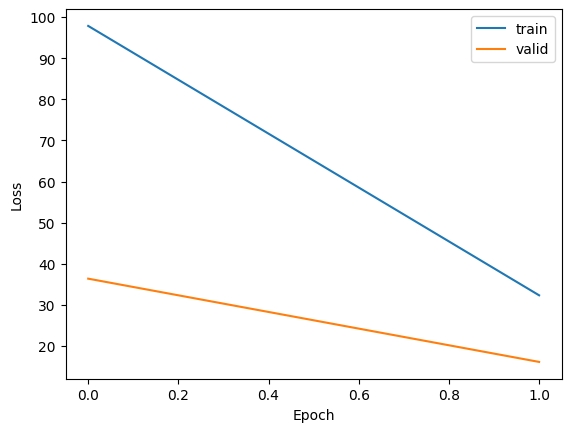

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [13]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")

def read_image(image_path):
  image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
  return tf.image.resize(image_array, (299, 299))

print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
  tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
  verbose=1
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
647/647 [==============================] - 672s 1s/step
Image embeddings shape: (82783, 128).


In [14]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
  # Get the embedding for the query.
  query_embedding = text_encoder(tf.convert_to_tensor(queries))
  # Normalize the query and the image embeddings.
  if normalize:
    image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
    query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
  # Compute the dot product between the query and the image embeddings.
  dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
  # Retrieve top k indices.
  results = tf.math.top_k(dot_similarity, k).indices.numpy()
  # Return matching image paths.
  return [[image_paths[idx] for idx in indices] for indices in results]

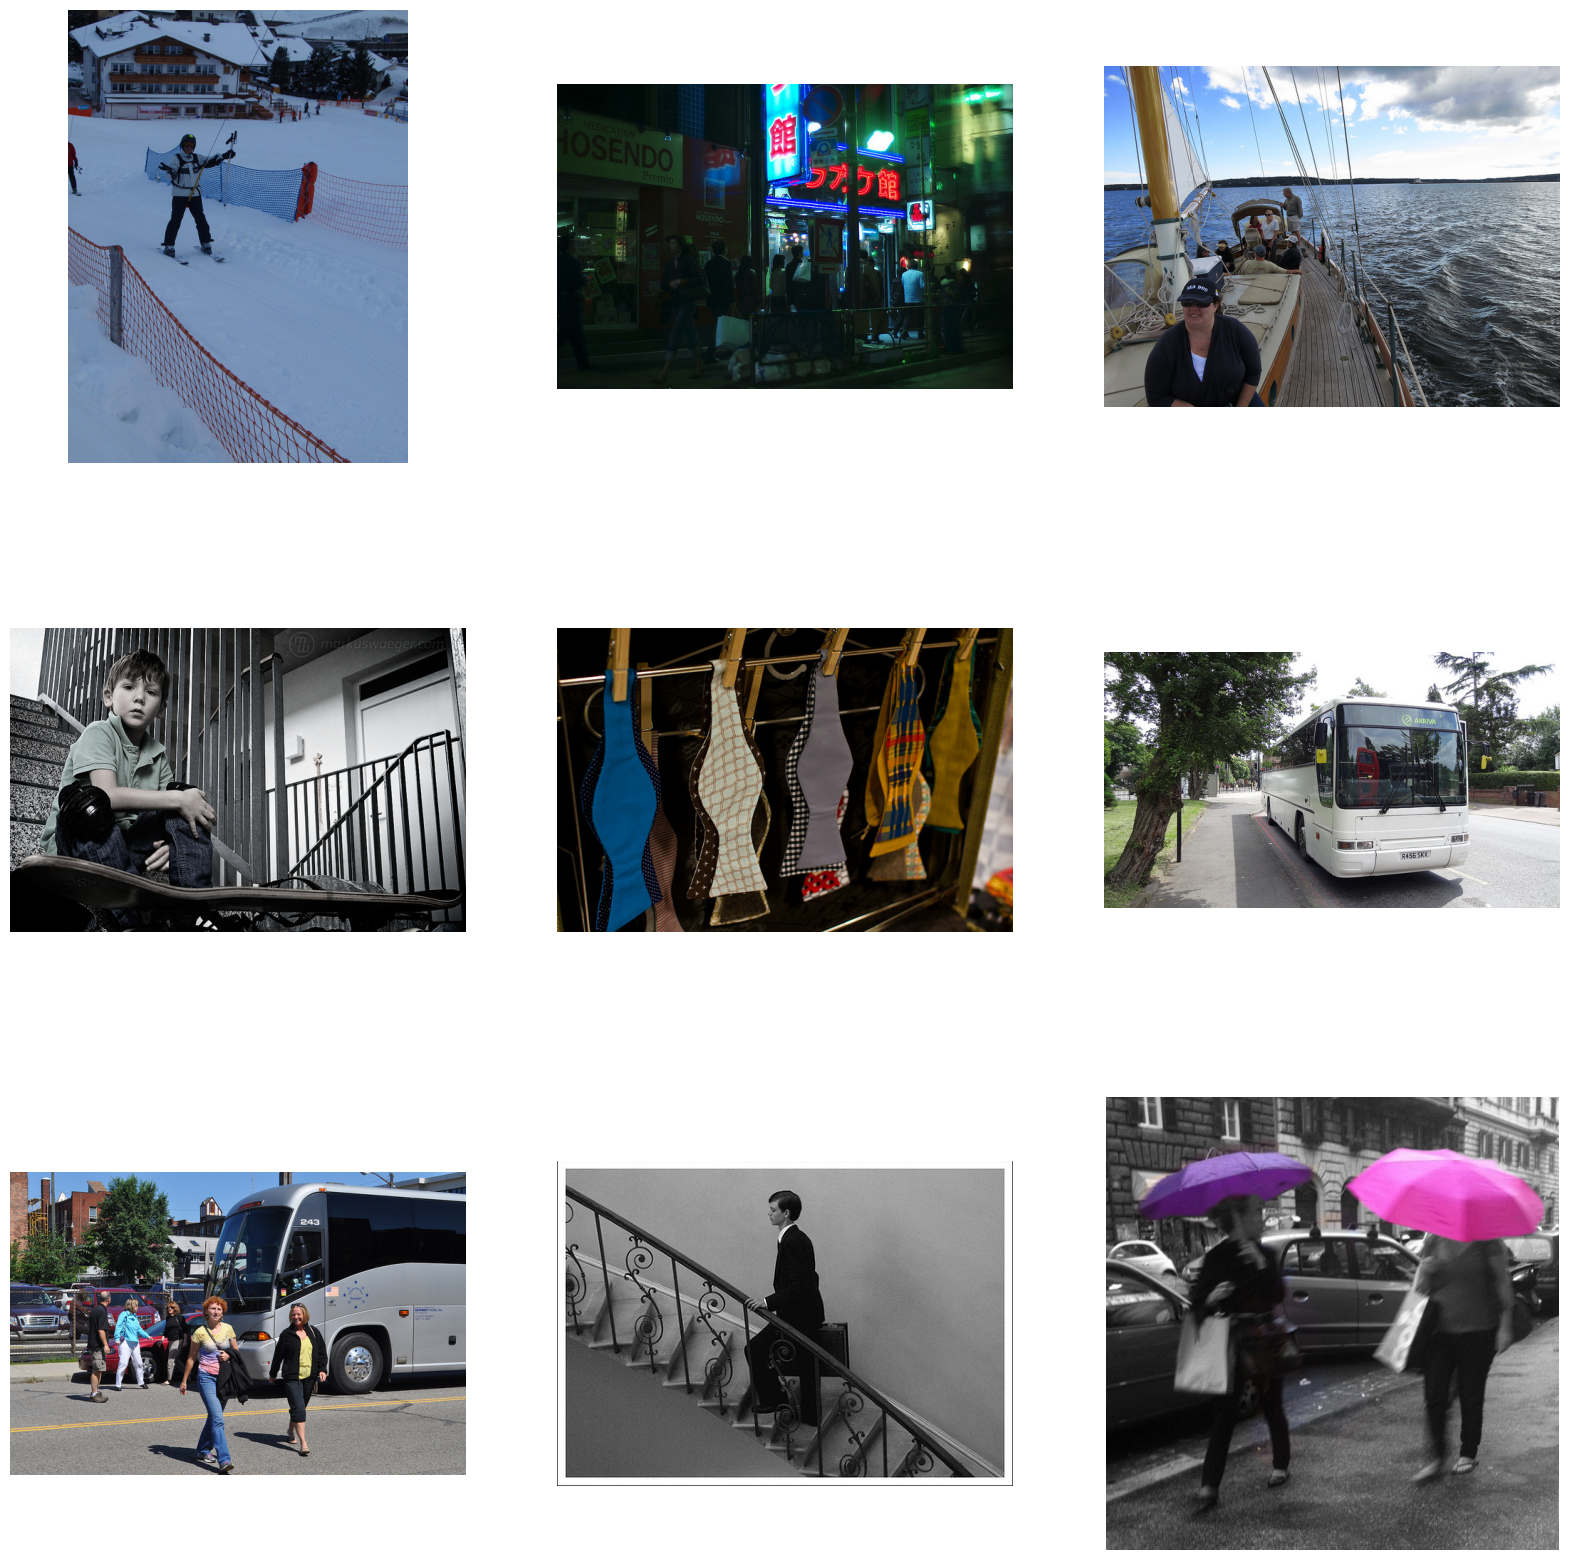

In [15]:
query = "a family standing next to the ocean on a sandy beach with a surf board"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(matches[i]))
  plt.axis("off")

In [16]:
def compute_top_k_accuracy(image_paths, k=100):
  hits = 0
  num_batches = int(np.ceil(len(image_paths) / batch_size))
  for idx in tqdm(range(num_batches)):
    start_idx = idx * batch_size
    end_idx = start_idx + batch_size
    current_image_paths = image_paths[start_idx:end_idx]
    queries = [
        image_path_to_caption[image_path][0] for image_path in current_image_paths
    ]
    result = find_matches(image_embeddings, queries, k)
    hits += sum(
        [
            image_path in matches
            for (image_path, matches) in list(zip(current_image_paths, result))
        ]
    )

  return hits / len(image_paths)

print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[train_size:])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")

Scoring training data...


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


Train accuracy: 1.967%
Scoring evaluation data...


100%|██████████| 624/624 [08:51<00:00,  1.17it/s]

Eval accuracy: 0.425%


11) Use the Transformers library to download a pretrained language model capable of generating text (e.g., GPT), and try generating more convincing Shakespearean text. You will need to use the model's `generate()` method—see Hugging Face's documentation for more details.

In [17]:
from transformers import TFOpenAIGPTLMHeadModel

In [18]:
model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFOpenAIGPTLMHeadModel: ['h.4.attn.bias', 'h.5.attn.bias', 'h.1.attn.bias', 'h.10.attn.bias', 'h.7.attn.bias', 'h.2.attn.bias', 'h.0.attn.bias', 'h.9.attn.bias', 'h.8.attn.bias', 'h.6.attn.bias', 'h.11.attn.bias', 'h.3.attn.bias']
- This IS expected if you are initializing TFOpenAIGPTLMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFOpenAIGPTLMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFOpenAIGPTLMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predicti

In [19]:
from transformers import OpenAIGPTTokenizer

In [20]:
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [21]:
tokenizer("hello everyone")

{'input_ids': [3570, 1473], 'attention_mask': [1, 1]}

In [22]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [23]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   524,   929,  1379,  2323,   500,  1092,   500,
         1808,   240,  1340,   793,   487,   544,   491,  1009,   240,
         1081,  2034,   507,   557,   524,  1163,   240,   488,  3836,
         4505,   485,   481,  7438,   498,   524,  2080,   239, 40477,
          256,   799,   841,   240,  6483],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   861,  1036,   500,   481,  1190,   498,   524,
         1158,   669,   813,   249,  2707,   524,  1158,   535,  3960,
          239,   256,   812,   580,  2259,   704,  6404,   240,  7232,
         6040,   240,   488,  2821,   481,  1276,   604,   664,   725,
         1820,   815,   485,  5018,   715],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   488,   616,  7339,   260,   595,   562,   512,
          240

In [24]:
for sequence in generated_sequences:
  text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
  print(text)
  print("-" * 80)

this royal throne of kings, this sceptred isle. his first breath comes in light in hours, yet here he is at last, looking upon it as his home, and bringing joy to the hearts of his children. 
'go away, lest
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, after being in the arms of his father when nai entered his father's service.'will be became your throne, mighty priest, and shall the world have no more power than to rule over
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, and this kingdom - not for you, but for your loved ones. now, you have come to an end, and you are one with the wild kingdom. think before you speak, for what
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle lies protected and guarded by several formidable forces - the zyranian 